# Deep Autoencoder applied to the stroke dataset
---

In this notebook, an *autoencoder* is implemented using `Pytorch`, `Pytorch Lighting` and the hyperparameter optimization is done by means of `Optuna` for several latent space ([0,100]) in order to compare it with some traditional feature extraction methods such us PCA and ICA. Since the data available is quite small, in this notebook we will apply the same autoencoder as in previous one but we will expand the training dataset. This is achieve by means of what is called the 'mix up' strategy.


First, import...


In [ ]:
%cd ..
%cd "Notebook utilities"

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

import glob
import os
import sys
import inspect
import gc

from Datasets import dataset
from Model_utilities import *
from Data_Preprocessing import get_arrays, to_vector, get_HCP
from ConvAutoencoder_noweigth import ConvAutoEncoder
from callbacks import MetricsCallback, LitProgressBar

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning.metrics.functional import accuracy

import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [ ]:
MODEL_SAVE_FOLDER = Path("SavedModels")

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(1234)
np.random.seed(1234)


## 1.1 Loading Dataset: FC matrices of *Stroke Patients*
---
The data is loaded from the .mat and .xlsl file and converted to a 3D array contining per each patient the correspondent fc matrix. Since not all patients have values, some of them are empty, those patients are simply removed and not consider. Furthermore NA values are converted to 0 values. Notice that since the autoencoder is an unsupervised model the labels are not needed in this part.

##### Vectorizing matrices
Following the paper we will exploit the symmetry of the matrix and convert each of them as vector

In [ ]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

#get data
mat_path = parentdir+'/DATA/FC_Stroke/FCMatrixImage_131subj.mat'
lang_path = parentdir+'/DATA/FC_Stroke/language_score.xlsx'
Normalize = True

fc_3d, language_score, ID = get_arrays(mat_path, lang_path, Normalize)

#vectorizing matrices
vect_mat = to_vector(fc_3d)

#standarize
for i in range(len(vect_mat)):
    vect_mat[i] = (vect_mat[i] - vect_mat[i].mean())/ vect_mat[i].std()

In [ ]:
#splitting the vectorize data in train-test using the sklearn library
vect_train, vect_test, score_train, score_test = train_test_split(vect_mat, language_score, test_size=0.3, shuffle=True)

In [ ]:
# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 2}

#Create dataset ----- This is the original dataset only
train_dataset = dataset(vect_train)
test_dataset = dataset(vect_test)

#all of them:
total_dataset = dataset(vect_mat)

#create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)
test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

## 1.2 Data Augmentation
---

In order to expand the dataset, we will make use of the mix up strategy.  In particular, a mixup augmentation is performed that consist on a random convex combination of raw inputs:

\begin{equation*}
    \hat{x} = \lambda x_i + (1 - \lambda) x_j
\end{equation*}

where $x_i$ and $x_j$ are raw input vectors and $\lambda$ are values sampled from the Beta distribution. 

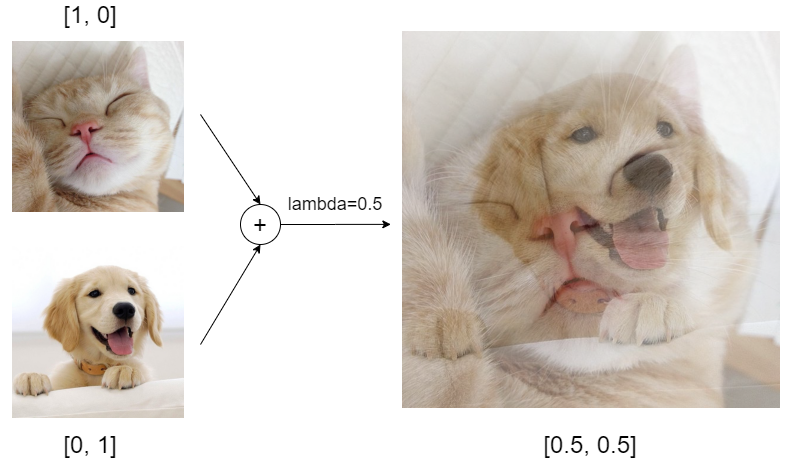


In [ ]:
def mixup_data(x, alpha=1.0, use_cuda=True):
    #Returns mixed inputs
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.shape[0]
    
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    
    return mixed_x

In [ ]:
#we concantenate to the original dataset samples obtained by mix_up 
new_data = vect_train
for i in range(90):
    train_mix_data = mixup_data(vect_train)
    new_data = np.concatenate([new_data, train_mix_data])

In [ ]:
#splitting the vectorize data in train-val using the sklearn library
new_train, new_val = train_test_split(new_data, test_size=0.2, shuffle=True)

train_dataset_augmented = dataset(new_train)
train_dataloader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, **params)

val_dataset_augmented = dataset(new_val)
val_dataloader_augmented = torch.utils.data.DataLoader(val_dataset_augmented, **params)

## 1.4 Hyperparameter Optimization
---

#### Autoencoder 
A convolutional autoencoder consisted of 3 conv layers and 2 linear layers are implemented using the `Pytorch Lighting` module.
The model is found in `ConvAutoencoder_noweight.py`. The only difference between the other one is that here we have fixed the weight decay in the opt.

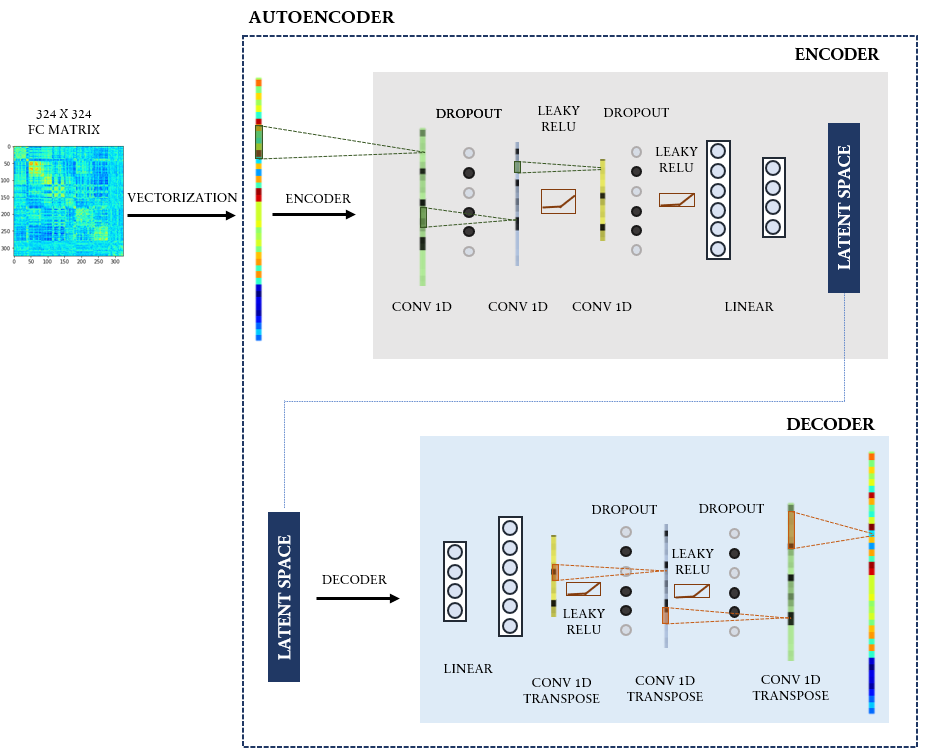

##### Hyperparameter search


Searching the optimal values using the `Optuna` library. This is done by minimizing the mean of the validation loss function 

In [ ]:
#---Hyperparameter Optimization with Optuna---#
def objective(trial: optuna.trial.Trial) -> float:
    
    optimizer = trial.suggest_categorical("optimizer", ["Adam"])

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    dropout = trial.suggest_float("dropout", 0.0, 1)
   
    conv1 =  trial.suggest_categorical("conv1", [8, 16, 32, 64, 128])
    
    conv2 =  trial.suggest_categorical("conv2", [8, 16, 32, 64, 128])
    
    conv3 =  trial.suggest_categorical("conv3", [8, 16, 32, 64, 128])
    
    fc = trial.suggest_categorical("fc", [8, 16, 32, 64, 128])

    #Convert to a dict 
    hyper_parameters = {
        'optimizer' : optimizer,
        'learning_rate' : learning_rate,
        'dropout' : dropout,
        'conv1' : conv1,
        'conv2' : conv2,
        'conv3': conv3, 
        'fc' : fc
    }
    
    cnn_autoencoder = ConvAutoEncoder(encoded_space_dim,hyper_parameters = hyper_parameters) 
    
    #Define model
    bar = LitProgressBar()
    metrics_callback = MetricsCallback()
    trainer = pl.Trainer(
        logger = True,
        limit_val_batches=1., #percentage of validation batches to be used
        checkpoint_callback=False, #Do not save models during hyperparams opt.
        max_epochs=50,
        gpus = 1 if torch.cuda.is_available() else None,
        callbacks = [PyTorchLightningPruningCallback(trial, monitor="val_loss"),metrics_callback, bar]
    )
    trainer.logger.log_hyperparams(hyper_parameters)

    #Train
    trainer.fit(cnn_autoencoder, train_dataloader_augmented, val_dataloader_augmented)

    return trainer.callback_metrics["val_loss"].item() 

In [ ]:
components = np.arange(10,95,5)
for encoded_space_dim in components:
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10) #Prune (=terminate a trial early) if the trial's best intermediate result is worse than the median of intermediate results of previous trials at the same step. It is used to avoid wasting time evaluating hyperparameter choices that are "really bad".
    study = optuna.create_study(study_name="Study_augmentated"+str(encoded_space_dim), storage="sqlite:///Study_augmentated"+str(encoded_space_dim)+".db", direction="minimize", pruner=pruner, load_if_exists=True)
   # study.optimize(objective, n_trials=100, timeout=None) #timeout = stop after this many seconds (set to None to proceed without time limitation)
    
    #Free RAM
    torch.cuda.empty_cache()
    gc.collect()
    del study

## 1.5 Training with optimal values

In [ ]:
components = np.arange(10,95,5)

for encoded_space_dim in components:
    #upload best study    
    study = optuna.create_study(study_name="Study_augmentated"+str(encoded_space_dim), storage="sqlite:///Study_augmentated"+str(encoded_space_dim)+".db", direction="minimize", pruner=pruner, load_if_exists=True)
    best_trial = study.best_trial
    best_hyperparameters = best_trial.params 
    
    #Checkpoints for the model
    bar = LitProgressBar()
    metrics_callback = MetricsCallback()
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True)
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='Models/experiments_90', filename='cnn_autoencoder-{epoch:02d}-{val_loss:.2f}', save_top_k=20, mode='min')

    #Define training
    trainer = pl.Trainer(gpus=1, max_epochs=500, callbacks=[metrics_callback, bar, early_stopping_callback])
    #Define model
    cnn_autoencoder = ConvAutoEncoder(encoded_space_dim, best_hyperparameters) 
    #Train
    trainer.fit(cnn_autoencoder, train_dataloader_augmented,val_dataloader_augmented)
    save_state("augmentated_best_strk_"+str(encoded_space_dim), trainer, metrics_callback.metrics)
    
    #relase RAM
    del study
    torch.cuda.empty_cache()
    gc.collect()

## 1.6 Saving values
---
Notice that in this stage we dont use the augmentated dataset, but rather we save the features, compute mse error and plot samples only for the original dataset (all of them)

In [ ]:
components = np.arange(10,95,5)
for encoded_space_dim in components:
    #loading state
    cnn_autoencoder_strk, metrics = load_state(ConvAutoEncoder, "augmentated_best_strk_"+str(encoded_space_dim))
    
    #plot_reconstruction_error(True, metrics)
    #plotting samples and saving it
    idx, re = plot_samples(cnn_autoencoder_strk, total_dataset, encoded_space_dim)
    
    #compute reconstructed errors
    mse, sd = reconstruction_error(cnn_autoencoder_strk, total_dataset, 10,vect_mat)
    np.savetxt('RESULTS/MSE_'+str(encoded_space_dim), [mse, sd])
    
    #SSIM index
    s_mean, s_sd =  sim_error(cnn_autoencoder_strk, total_dataset, encoded_space_dim,vect_mat)
    np.savetxt('RESULTS/SSIM_'+str(encoded_space_dim), [s_mean, s_sd])
    
    #save latent features -
    save_features(cnn_autoencoder_strk, total_dataset, encoded_space_dim)

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib import style

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


In [ ]:
cnn_autoencoder_strk, metrics = load_state(ConvAutoEncoder, "augmentated_best_strk_"+str(90))
plot_reconstruction_error(90, True, metrics)